In [2]:
import ROOT
import math
# Colors
from ROOT import kYellow, kBlue, kRed, kGreen
import numpy as np
from rootpy.plotting import Hist, HistStack, Legend, Canvas, set_style
from rootpy.plotting.style import get_style, set_style
from rootpy.plotting.utils import draw
from rootpy.interactive import wait
import rootpy.plotting.root2matplotlib as rplt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from root_numpy import root2array, tree2array
from root_numpy import testdata, fill_hist
import pandas as pd

## Matplotlib Function

In [3]:
def getTHLimits(file_path, ttree, var):
    g_min = 99999999999.
    g_max = -99999999999.
    aux = ROOT.TFile.Open(file_path)
    tree = aux.Get(ttree)
    maxv=int(round(tree.GetMaximum(var)))
    minv=int(round(tree.GetMinimum(var)))
    return minv-1.,maxv+1.

In [4]:
def count_entries(df, names):
    count = df['sample'].value_counts()
    values = []
    for var in names:
        try:
            values.append(count.get_value(var))
        except:
            values.append(0)
            continue
    return values

In [5]:
def hist_gen(file, data, background, signal, ttree, var, region, nbins, s_amp):
    
    rfile = ROOT.TFile(file)
    intree = rfile.Get(ttree)
    array = tree2array(intree)
    df = pd.DataFrame(array)
    df = df.loc[df['m_region'] == region]
        
    # data, background and signal are filenames arrays
    arrB = df.loc[df['sample'].isin(background)]
    arrS = df.loc[df['sample'].isin(signal)]
    arrD = df.loc[df['sample'].isin(data)]
    
    # Integrals
    intB = []
    intS = []
    intD = []
    
    # set the style
    style = get_style('ATLAS')
    style.SetEndErrorSize(3)
    set_style(style)
    
    # create histograms
    hmin, hmax = getTHLimits(file, ttree, var)
    h = Hist(nbins, hmin, hmax, markersize=0)
    h_sig = []
    h_bkg = []
    colorsS = ['red', 'firebrick']
    colorsB = ['blue', 'green', 'yellow', 'cyan', 'magenta', 'navy', 'orange', 'yellowgreen', 'chocolate', 'darkviolet', 'm', 'steelblue']
    for i, s in enumerate(signal):
        h_aux = Hist(nbins, hmin, hmax, title=s, color=colorsS[i])
        arr_aux = arrS.loc[arrS['sample'] == s]
        fill_hist(h_aux, arr_aux.loc[:,var], arr_aux.loc[:,'EventWeight'])
        intS.append(h_aux.Integral())
        h_sig.append(h_aux*s_amp)
    for i, b in enumerate(background):
        h_aux = h.Clone(title=b, legendstyle='F')
        arr_aux = arrB.loc[arrB['sample'] == b]
        fill_hist(h_aux, arr_aux.loc[:,var], arr_aux.loc[:,'EventWeight'])
        h_aux.fillstyle = 'solid'
        h_aux.fillcolor = colorsB[i]
        h_aux.linecolor = colorsB[i]
        h_aux.linewidth = 0
        intB.append(h_aux.Integral())
        h_bkg.append(h_aux)

    h_data = h.Clone(title=data[0])
    h_data.markersize = 1.2
    arr_aux = arrD.loc[arrD['sample'] == data[0]]
    fill_hist(h_data, arr_aux.loc[:,var], arr_aux.loc[:,'EventWeight'])
    intD.append(h_data.Integral())
    
    # histograms stack
    stack = HistStack(h_bkg, drawstyle='HIST E1 X0')
    
    # plot with ROOT
    canvas = Canvas(width=1000, height=800)
    draw([stack, h_data, h_sig[0]], xtitle=var, ytitle='Events', pad=canvas)
    
    # set the number of expected legend entries
    legend = Legend(h_bkg, leftmargin=0.25, margin=0.1, pad=canvas)
    legend.Draw()
    label = ROOT.TText(0.2, 0.6, 'ROOT')
    label.SetTextFont(43)
    label.SetTextSize(15)
    label.SetNDC()
    label.Draw()
    canvas.Modified()
    canvas.Update()

    # plot with matplotlib
    set_style('ATLAS')
    
    fig = plt.figure(figsize=(9, 8), dpi=100)
    grid = plt.GridSpec(5, 2, hspace=0.1)
    
    # Histograms plot
    his = fig.add_subplot(grid[:-1, :])
    his.xaxis.set_minor_locator(AutoMinorLocator())
    his.yaxis.set_minor_locator(AutoMinorLocator())
    his.tick_params(labelbottom=False)
    #his.set_xticks([])
    rplt.bar(stack, stacked=True, axes=his)
    rplt.bar(h_sig, stacked=False, axes=his)
    rplt.errorbar(h_data, xerr=False, emptybins=False, axes=his, snap=False)
    # check: http://www.rootpy.org/reference/generated/rootpy.plotting.root2matplotlib.errorbar.html
    # check: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.errorbar.html
    his.set_ylabel('Events')
    leg = plt.legend()
    his.grid()
    
    ### Residuals plot
    
    # Histograms operations
    #h_rat = h_data.Clone()
    #h_bkg_sum = h.Clone()
    #for h_ in h_bkg:
    #    h_bkg_sum.Add(h_, 1)
    #h_rat.Add(h_bkg_sum,-1)
    #h_rat.Divide(h_bkg_sum)
       
    # Bin by bin method
    h_rat = h.Clone()
    h_rat.markersize = 1.2
    residual = []
    for i in range(nbins):
        d = h_data.GetBinContent(i)
        b = stack.GetStack().Last().GetBinContent(i) 
        if(d!=0): # nule data points will be ignored
            value = (d-b)/b
            h_rat.SetBinContent(i,value)   
    
    res = fig.add_subplot(grid[-1, :], sharex=his)
    res.xaxis.set_minor_locator(AutoMinorLocator())
    res.yaxis.set_minor_locator(AutoMinorLocator())
    rplt.errorbar(h_rat, xerr=False, emptybins=False, axes=res, snap=False)
    res.set_ylabel('(data-bkg)/bkg')
    res.set_xlabel(var)
    #res.set_ylim((-3,3))
    res.grid()
    
    fig.suptitle("Variable: "+var+". Region: "+region+".", fontsize=14)
    plotname = "plots/"+var+"_"+region+".png"
    plt.savefig(plotname)    
        
    fig.tight_layout()
        
    if not ROOT.gROOT.IsBatch():
        plt.show()
        wait(True)
    canvas.Draw()
    
    print("Plot saved in", plotname)
    
    ## Show entries and integral values

    names = filesB+filesS+filesD
    values = intB+intS+intD
    entries = count_entries(df, names)

    print('%-15s%-15s%-10s' % ("samplename", "entries", "integral"))
    for i in range(len(names)):
        print('%-15s%-15i%-10f' % (names[i], entries[i], values[i]))
    
    return
    

INFO:rootpy.plotting.style] using ROOT style 'ATLAS'
INFO:rootpy.plotting.style] using ROOT style 'ATLAS'


Plot saved in plots/m_hhm_PreSel_2tag.png
samplename     entries        integral  
W              13             0.137338  
WWPw           0              0.000000  
WZPw           1              0.024962  
ZZPw           10             0.224800  
ZeeSh221       31             0.697578  
ZtautauSh221   154            2.711989  
fakes          784            2.014077  
stopWt         0              0.000000  
stops          0              0.000000  
stopt          0              0.000000  
ttbar          2              0.753713  
Xtohh1000      18063          21.218024 
Xtohh2000      0              0.000000  
data           6              6.000000  


/home/andrea/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


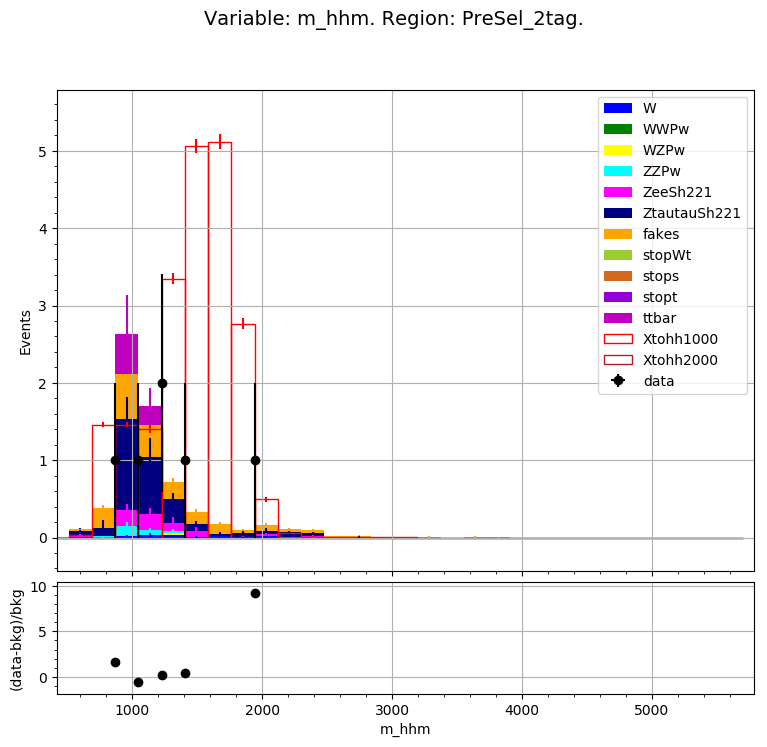

In [7]:
# Base directory
b = "/home/andrea/Escritorio/CERN data/Try3/all.root"
# Background files array
filesB = ['W', 'WWPw', 'WZPw', 'ZZPw', 'ZeeSh221', 'ZtautauSh221', 'fakes', 'stopWt', 'stops', 'stopt', 'ttbar'] 
# Signal files array
filesS = ['Xtohh1000', 'Xtohh2000']
# Data files array
filesD = ['data']
# Histogram generation
hist_gen(b, filesD, filesB, filesS, "Nominal", "m_hhm", "PreSel_2tag", 30, 1)

## TODO:

- Arreglar formato de plot. https://root.cern.ch/doc/master/classTHistPainter.html#HP01
- Calcular entries e integrales de los histogramas (chicos) para la variable m_hhm con cada región, y ponerlos en la tabla https://docs.google.com/spreadsheets/d/1iKdwp5v5bM2gT5P_0EFJ63zlqb2CzqcPz8KmJ4kFRX4/edit#gid=1024906735 
- https://git.km3net.de/km3py/km3pipe/commit/f8b1d0ad4c14695d9cc0693697742a914e568221
